In [6]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp

from transformer_payne import TransformerPayne
import matplotlib.pyplot as plt
import numpy as np

# Fitting with TransformerPayne

This notebook demonstrates a straightforward fitting procedure using **TransformerPayne**.  
The workflow consists of three steps:

1. **Generate a mock spectrum.**  
2. **Define a loss function.**  
3. **Run gradient-based fitting.**

## 1. Generate a mock spectrum

We will build a model with a restricted set of free parameters.  
Although the underlying model works with individual elemental abundances, here we limit the parameters to:

- overall metallicity ([M/H])  
- **α-element** abundance (following the MARCS-grid convention)  
- carbon abundance ([C/Fe])

Because TransformerPayne predicts **intensity**, we will perform the fitting directly in intensity space.

In [ ]:
from transformer_payne import METALS
ALPHA_AND_O_MARCS_SDSS = ["Ne", "Mg", "Si", "S", "Ar", "Ca", "Ti", "O"]

def get_restricted_emulator():
    """
    Returns
    -------
    predict_intensity function:
        predict_intensity(wavelength, mu, p_prim)
        Note that:
        - logteff in [log10(4000), log10(8000)]
        - logg in [2.0, 5.0]
        - vmic in [0.0, 5.0]
        - [M/H] in [-2.5, 1.0]
        - [alpha/Fe] in [-1.0, 1.0]
        - [C/Fe] in [-1.0, 1.0]
        - mu in [0.0, 1.0]
    """

    # Load the emulator:
    spec_emulator = TransformerPayne.download()

    # Get indexes of the parameters as defined in the emulator:
    parameter_indices = {label: i for i, label in enumerate(spec_emulator.stellar_parameter_names)}

    # logteff, logg, vmic:
    logteff_index = parameter_indices["logteff"]
    logg_index = parameter_indices["logg"]
    vmic_index = parameter_indices["vmic"]
    # And abundances:
    metals_indices = jnp.array([parameter_indices[label] for label in METALS[:90]])
    alpha_indices = jnp.array([parameter_indices[label] for label in ALPHA_AND_O_MARCS_SDSS])
    carbon_index = parameter_indices["C"]
    
    @jax.jit
    def predict_intensity(log_wavelengths: jnp.ndarray, mu:float, p_prim: jnp.ndarray) -> jnp.ndarray:
        # p_prim : (logteff, logg, vmic, [M/H], [alpha/Fe], [C/Fe])
        p = jnp.array(spec_emulator.solar_parameters)

        p = p.at[logteff_index].set(p_prim[0])
        p = p.at[logg_index].set(p_prim[1])
        p = p.at[vmic_index].set(p_prim[2])
        p = p.at[metals_indices].add(p_prim[3])
        p = p.at[alpha_indices].add(p_prim[4])
        p = p.at[carbon_index].add(p_prim[5])

        intensity = spec_emulator.intensity(log_wavelengths, mu, p) 
        # ntensity[..., 0] : including lines
        # intensity[..., 1] : continuum
        return intensity[..., 0] / intensity[..., 1] # normalized to continuum

    return predict_intensity

predict_intensity = get_restricted_emulator()

In [117]:
no_wavelengths = 4000
%time _ = predict_intensity(jnp.linspace(0, 1, no_wavelengths), 0.5, jnp.array([4.0, 4.0, 1.0, 0.0, 0.0, 0.0]))

CPU times: user 1.98 s, sys: 73.8 ms, total: 2.05 s
Wall time: 2.25 s


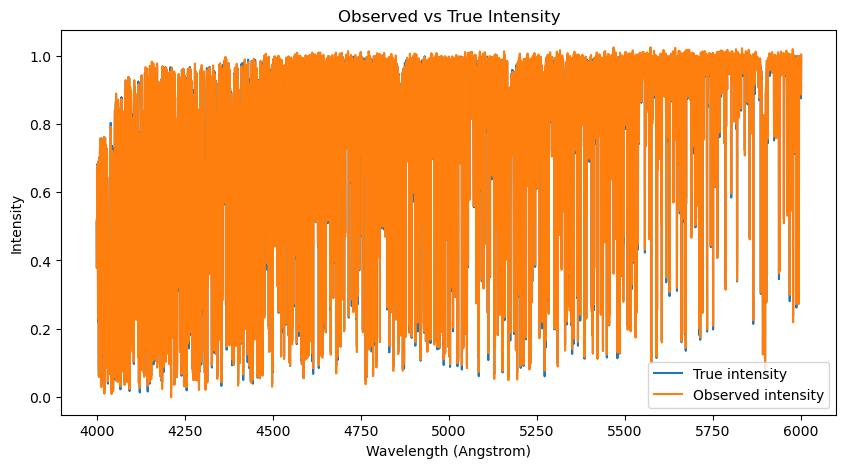

In [159]:
p_true = jnp.array([np.log10(5000),4.0, 1.0, 0.0, 0.0, 0.0])
log_wavelengths = np.log10(np.linspace(4000, 6000, no_wavelengths), dtype=np.float64)
mu = 1.0

w = 10 ** log_wavelengths

true_intensity = predict_intensity(log_wavelengths, mu, p_true).block_until_ready()
noise_sigma = 0.01
noise = np.random.normal(0, noise_sigma, size=true_intensity.shape)
observed_intensity = true_intensity + noise

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(w, true_intensity, label="True intensity")
ax.plot(w, observed_intensity, label="Observed intensity")
ax.set_xlabel("Wavelength (Angstrom)")
ax.set_ylabel("Intensity")
ax.set_title("Observed vs True Intensity")
ax.legend()
plt.show()

## Define a loss function

In [160]:
def get_loss(observed_intensity, log_wavelengths, mu):
    """
    Returns the loss function for the given observed intensity and wavelengths.
    """
    def loss(p_prim):
        predicted_intensity = predict_intensity(log_wavelengths, mu, p_prim)
        return jnp.mean((predicted_intensity - observed_intensity) ** 2) 
    return loss
    
loss = get_loss(observed_intensity, log_wavelengths, mu)

In [161]:
# plot logteff vs logg grid of MSE
logteff_range = np.linspace(np.log10(4500), np.log10(5500), 10)
logg_range = np.linspace(2.0, 5.0, 10)
logteff_grid, logg_grid = np.meshgrid(logteff_range, logg_range)

loss_grid = np.zeros(logteff_grid.shape)

for i in range(logteff_grid.shape[0]):
    print(f"i = {i}")
    for j in range(logteff_grid.shape[1]):
        p_prim = jnp.array([logteff_grid[i, j], logg_grid[i, j], 1.0, 0.0, 0.0, 0.0])
        loss_grid[i, j] = loss(p_prim)

i = 0
i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9


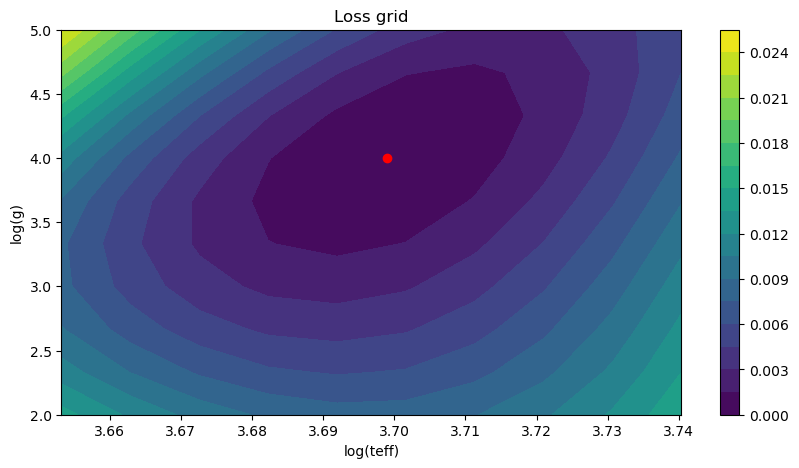

In [162]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

c = ax.contourf(logteff_grid, logg_grid, loss_grid, levels=20)

# true:
ax.scatter(np.log10(5000), 4.0, color="red", label="True parameters")

ax.set_xlabel("log(teff)")
ax.set_ylabel("log(g)")
ax.set_title("Loss grid")
plt.colorbar(c, ax=ax)
plt.show()
# plot logteff vs vmic grid of MSE

### Example of gradient based optimization

In [183]:
def get_value_and_grad_of_loss_function(observed_intensity, log_wavelengths, mu):
    """
    Returns the loss function for the given observed intensity and wavelengths.
    """
    def loss(p_prim):
        predicted_intensity = predict_intensity(log_wavelengths, mu, p_prim)
        return jnp.mean((predicted_intensity - observed_intensity) ** 2) 
    return jax.value_and_grad(loss)
    
val_and_grad = get_value_and_grad_of_loss_function(observed_intensity, log_wavelengths, mu)

In [ ]:
# --- helper: sample uniform random start points in the allowed box ------------
PARAM_BOUNDS = jnp.array([
    [jnp.log10(4000.0), jnp.log10(8000.0)],   # logTeff
    [2.0,               5.0],                # logg
    [0.0,               5.0],                # vmic
    [-2.5,              1.0],                # [M/H]
    [-1.0,              1.0],                # [α/Fe]
    [-1.0,              1.0],                # [C/Fe]
])

def sample_params(rng: jax.random.PRNGKey) -> jnp.ndarray:
    """Draw a random parameter vector inside PARAM_BOUNDS."""
    u = jax.random.uniform(rng, shape=(6,))
    return PARAM_BOUNDS[:, 0] + u * (PARAM_BOUNDS[:, 1] - PARAM_BOUNDS[:, 0])

# ---------------------------------------------------------------------------
# Hyper-parameters
# ---------------------------------------------------------------------------
LR        : float = 0.2     # learning-rate
N_STEPS   : int   = 200     # gradient-descent iterations
KEY               = jax.random.PRNGKey(42)

# ---------------------------------------------------------------------------
# Generate one random starting point inside the allowed box
# (re-use PARAM_BOUNDS and sample_params from earlier)
# ---------------------------------------------------------------------------
p = sample_params(KEY)

# ---------------------------------------------------------------------------
# Main optimisation loop
# ---------------------------------------------------------------------------
print(" step |        loss |  logTeff   logg    vmic    [M/H]  [α/Fe]   [C/Fe]")
print("-" * 79)

for step in range(N_STEPS):
    loss_val, grad = val_and_grad(p)          # compiled, fast
    print(f"{step:5d} | {loss_val:11.4e} | "
          f"{p[0]:8.5f}  {p[1]:5.3f}  {p[2]:6.3f}  "
          f"{p[3]:6.3f}  {p[4]:6.3f}  {p[5]:7.3f}")
    p = p - LR * grad                         # GD update


 step |        loss |  logTeff   logg    vmic    [M/H]  [α/Fe]   [C/Fe]
-------------------------------------------------------------------------------
    0 |  2.3790e-02 |  3.79611  2.360   1.518   0.910  -0.806   -0.458
    1 |  2.3630e-02 |  3.78968  2.361   1.517   0.907  -0.805   -0.459
    2 |  2.3534e-02 |  3.79087  2.363   1.516   0.903  -0.805   -0.460
    3 |  2.3443e-02 |  3.79007  2.365   1.515   0.899  -0.804   -0.460
    4 |  2.3352e-02 |  3.78979  2.366   1.515   0.895  -0.803   -0.461
    5 |  2.3261e-02 |  3.78938  2.368   1.514   0.892  -0.803   -0.462
    6 |  2.3170e-02 |  3.78899  2.369   1.513   0.888  -0.802   -0.462
    7 |  2.3079e-02 |  3.78860  2.371   1.513   0.884  -0.802   -0.463
    8 |  2.2989e-02 |  3.78821  2.372   1.512   0.880  -0.801   -0.463
    9 |  2.2898e-02 |  3.78781  2.374   1.511   0.876  -0.800   -0.464
   10 |  2.2808e-02 |  3.78742  2.376   1.510   0.873  -0.800   -0.465
   11 |  2.2717e-02 |  3.78703  2.377   1.510   0.869  -0.799   -0.